## Produce mock data

Now that we have explore in the previous notebooks the workflow for the four different indicators, we are going to produce mock data to star exploring graphs and visualizations. The workflow that we are going to use would be covered in the table of contents:

## Table of Contents
- ### [Python libraries](#libraries)
- ### [1. Explore user data](#importData)
- ### [2. Default crop and pasture data](#crop_data)
- ### [3. Generate risk map](#risk)
    - #### [3.1 Unsustainable water use risk](#waterRisk)
    - #### [3.2 Deforestation risk](#deforestationRisk)
    - #### [3.3 Carbon emissions due to land use change risk](#carbonRisk)
    - #### [3.4 Biodiverstity loss due to land use change risk](#biodiversityRisk)
- ### [4. Get metrics for user data](#metric)
- ### [5. Final notes](#finalNotes)

<a id='libraries'></a>
## Python libraries

In [1]:
import geopandas as gpd
import pandas as pd

from processing.geolocating_data import GeolocateAddress

In [2]:
import rasterio as rio
import numpy as np
import rasterio.plot
import matplotlib.pyplot as plt
from rasterio.plot import show_hist


from rasterstats import gen_zonal_stats
from rasterstats import zonal_stats

In [3]:
# import lib
import time
import os
import io
import requests
import zipfile

<a id='importData'></a>
## 1. Explore user data

In [5]:
processed_path =  '../../datasets/processed/'
raw_path =  '../../datasets/raw/'

In [6]:
#import user data
supply_data = gpd.read_file(processed_path + 'user_data/located_lg_data_polygon_v2.shp')
supply_data.head()

,Material,Material d,Volume,Country,Address,Latitude,Longitude,Location t,Accuracy,geometry
0,Rubber,None,2400,China,None,None,None,Unknown,Low,"MULTIPOLYGON (((73.49973 39.38174, 73.50468 39..."
1,Rubber,None,1300,Malaysia,None,None,None,Unknown,Low,"MULTIPOLYGON (((98.93721 5.68384, 98.93771 5.6..."
2,Rubber,None,1000,United States,None,None,None,Unknown,Low,"MULTIPOLYGON (((-180.00000 51.79409, -180.0000..."
3,Rubber,None,730,Japan,None,None,None,Unknown,Low,"MULTIPOLYGON (((122.71418 24.44983, 122.71457 ..."
4,Rubber,None,490,India,None,None,None,Unknown,Low,"MULTIPOLYGON (((68.11138 23.60145, 68.13528 23..."


In [7]:
#user data is in the 4326 projection
supply_data = supply_data.set_crs("EPSG:4326")

In [8]:
#check unique commodities for calculating the risk maps
set(supply_data['Material'])

{'Cotton', 'Leather', 'Rubber'}

<a id='crop_data'></a>
## 2. Default crop and pasture data

For the generation of the mock data we're going to work on a first iteration producing generic risk map which would be used for default values in other crops and pasture activities.

The main datasets that have been identified for the calculation of either the default values (crop and pasture) or specific commodities (e.g. cotton) have been collected [here](https://docs.google.com/spreadsheets/d/1ehQi8_cvfN4OhTfULHNKegqlygWJrob27LaUmFstuZY/edit?usp=drive_web&ouid=107560875301636842650).

For this mock data production we will use the following datasets:

- generic crops:
    - harvest area fraction 2000 rest of crops (MAPSPAM): https://www.mapspam.info/data/
    - Yield 2000 rest of crops (MAPSPAM): https://www.mapspam.info/data/

- generic pasture:
    - harvest area fractio 2000 (Earthstat): http://www.earthstat.org/cropland-pasture-area-2000/
    - Yield by country in 2000 (FAO): http://www.fao.org/faostat/en/#data/QL
    
NOTE: We will need to produce a raster with the same resolution as the harvest area with the yield information by country.

#### Default crop data:


In [16]:
#DOWNLOAD DEFAULT CROP DATA
url_ag_ha_2010 = 'https://s3.amazonaws.com/mapspam/2010/v2.0/geotiff/spam2010v2r0_global_harv_area.geotiff.zip'
url__ag_yield_2010 = 'https://s3.amazonaws.com/mapspam/2017/ssa/v2.1/geotiff/spam2017v2r1_ssa_yield.geotiff.zip'
local_path = '../../datasets/raw/crop_data/default_crop'

if not os.path.isdir(local_path):
    os.mkdir(local_path)
print('Downloading agr harvest area dataset...')
r = requests.get(url_ag_ha_2010)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done harvest area!")
z.extractall(path=local_path) # extract to folder

print('Downloading agr yield dataset...')
r = requests.get(url__ag_yield_2010)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")
z.extractall(path=local_path) # extract to folder
print("Done yield!")

Done harvest area!
Done
Done yield!


In [21]:
default_ag_ha_2010 = "../../datasets/raw/crop_data/default_crop/spam2010V2r0_global_H_REST_A.tif"
default_ag_yield_2010 = "../../datasets/raw/crop_data/default_crop/spam2017V2r1_SSA_Y_REST_A.tif"

EPSG:4326
BoundingBox(left=-180.0, bottom=-89.99928, right=179.99856, top=90.0)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1.0, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.083333, 0.0, -180.0,
       0.0, -0.083333, 90.0), 'tiled': False, 'interleave': 'band'}


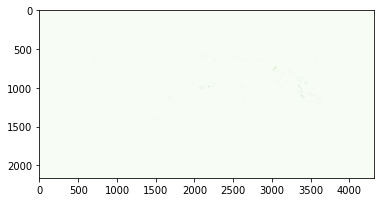

In [19]:
#explore download raster - harvest area fraction
a = rasterio.open(default_ag_ha_2010)
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Greens')
plt.show()

EPSG:4326
BoundingBox(left=-180.0, bottom=-89.99928, right=179.99856, top=90.0)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1.0, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.083333, 0.0, -180.0,
       0.0, -0.083333, 90.0), 'tiled': False, 'interleave': 'band'}


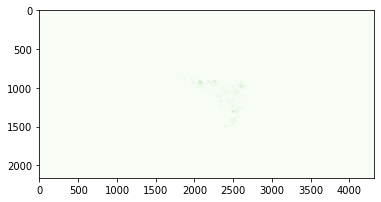

In [22]:
#explore download raster - harvest area yield
a = rasterio.open(default_ag_yield_2010)
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Greens')
plt.show()

#### Default pasture data:

In [75]:
#DOWNLOAD DEFAULT PASTURE DATA:
url_ps_ha_2000 = 'https://s3.us-east-2.amazonaws.com/earthstatdata/CroplandPastureArea2000_Geotiff.zip'
local_path = '../../datasets/raw/crop_data/default_pasture'

if not os.path.isdir(local_path):
    os.mkdir(local_path)
print('Downloading agr harvest area dataset...')
r = requests.get(url_ps_ha_2000)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done harvest area pasture!")
z.extractall(path=local_path) # extract to folder


Done harvest area pasture!


EPSG:4326
BoundingBox(left=-180.0, bottom=-90.0, right=179.99999999997954, top=89.99999999998977)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.402823e+38, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0833333333333286, 0.0, -180.0,
       0.0, -0.0833333333333286, 89.99999999998977), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'interleave': 'band'}


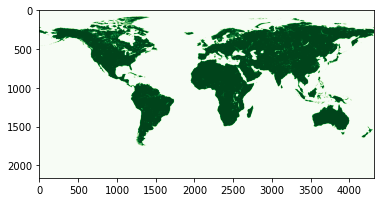

In [27]:
#explore download raster - harvest area fraction
a = rasterio.open(default_pasture_ha_2000)
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Greens')
plt.show()

#### Generate yield for pasture
As the generic yield in not ptovided for pasture, we could produce the average yield by country using data from FAO. The data for the default pasture yield can be obtained from [FAOSTAT](http://www.fao.org/faostat/en/#data/QL)

    """
    "http://fenixservices.fao.org/faostat/api/v1/en/data/QL?area=5000%3E&area_cs=FAO&element=2413&item=919&item_cs=FAO&year=2000&show_codes=true&show_unit=true&show_flags=true&null_values=false&output_type=csv"
    """

In [ ]:
url = "http://fenixservices.fao.org/faostat/api/v1/en/data/QL?area=5000%3E&area_cs=FAO&element=2413&item=919&item_cs=FAO&year=2000&show_codes=true&show_unit=true&show_flags=true&null_values=false&output_type=csv"

In [26]:
default_pasture_ha_2000 = "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m.tif"

In [73]:
pasture_yield_2000 = pd.read_csv('../../datasets/raw/crop_data/default_pasture/FAOSTAT_data_6-22-2021_yield.csv')
pasture_yield_2000.head()

,Domain Code,Domain,Area Code (FAO),Area,Element Code,Element,Item Code (FAO),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,QL,Livestock Primary,2,Afghanistan,5420,Yield,919,"Hides, cattle, fresh",2000,2000,hg/An,295,Fc,Calculated data
1,QL,Livestock Primary,3,Albania,5420,Yield,919,"Hides, cattle, fresh",2000,2000,hg/An,219,Fc,Calculated data
2,QL,Livestock Primary,4,Algeria,5420,Yield,919,"Hides, cattle, fresh",2000,2000,hg/An,240,Fc,Calculated data
3,QL,Livestock Primary,7,Angola,5420,Yield,919,"Hides, cattle, fresh",2000,2000,hg/An,285,Fc,Calculated data
4,QL,Livestock Primary,8,Antigua and Barbuda,5420,Yield,919,"Hides, cattle, fresh",2000,2000,hg/An,224,Fc,Calculated data


In [83]:
retrieved_geoms = []
for i, row in pasture_yield_2000.iterrows():
    try:
        geo_request = GeolocateAddress(query=row['Area'])
        gdf = gpd.GeoDataFrame.from_features(geo_request.polygon_json, crs='epsg:4326')
        geom = gdf['geometry'][0]
    except:
        print(row['Area'])
        geom = None
    retrieved_geoms.append(geom)

Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Afghanistan with timeout=180
Geocoded "Afghanistan" to (66.2385139, 33.7680065)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Afghanistan')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Afghanistan
Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Albania with timeout=180
Geocoded "Albania" to (19.9999619, 41.000028)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Albania')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Albania
Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Algeri

Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Bolivia+%28Plurinational+State+of%29 with timeout=180
Geocoded "Bolivia (Plurinational State of)" to (-64.9912286, -17.0568696)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Bolivia (Plurinational State of)')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Bolivia+%28Plurinational+State+of%29
Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Bosnia+and+Herzegovina with timeout=180
Geocoded "Bosnia and Herzegovina" to (17.5961467, 44.3053476)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Bosnia and Herzegovina')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Bosnia+and+Herzegovina
Pausing 1 seconds before ma

Nominatim could not geocode query "China, Taiwan Province of"
China, Taiwan Province of
Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Colombia with timeout=180
Geocoded "Colombia" to (-73.783892, 2.8894434)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Colombia')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Colombia
Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Comoros with timeout=180
Geocoded "Comoros" to (44.2832964, -12.2045176)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Comoros')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Comoros
Pausing 1 seconds before making HTTP GET request
Get htt

Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Equatorial+Guinea with timeout=180
Geocoded "Equatorial Guinea" to (10.5170357, 1.613172)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Equatorial Guinea')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Equatorial+Guinea
Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Eritrea with timeout=180
Geocoded "Eritrea" to (37.9999668, 15.9500319)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Eritrea')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Eritrea
Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&li

Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Guatemala with timeout=180
Geocoded "Guatemala" to (-89.8988087, 15.6356088)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Guatemala')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Guatemala
Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Guinea with timeout=180
Geocoded "Guinea" to (-10.7083587, 10.7226226)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Guinea')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Guinea
Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Guinea-Bissau w

Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Kenya with timeout=180
Geocoded "Kenya" to (38.4313975, 1.4419683)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Kenya')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Kenya
Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Kuwait with timeout=180
Geocoded "Kuwait" to (47.4979476, 29.2733964)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Kuwait')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Kuwait
Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Kyrgyzstan with timeout=180
Geocod

Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Mexico with timeout=180
Geocoded "Mexico" to (-100.0000375, 22.5000485)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Mexico')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Mexico
Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Micronesia+%28Federated+States+of%29 with timeout=180
Geocoded "Micronesia (Federated States of)" to (-77.0405464, 38.9073892)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Micronesia (Federated States of)')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Micronesia+%28Federated+States+of%29
OSM returned a Point as the geometry
Paus

Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Palestine with timeout=180
Geocoded "Palestine" to (35.27386547291496, 31.94696655)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Palestine')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Palestine
Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Panama with timeout=180
Geocoded "Panama" to (-81.1308434, 8.559559)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Panama')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Panama
Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Papua+New+Guinea with timeout=180
Geocoded "Papua New Guine

Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Samoa with timeout=180
Geocoded "Samoa" to (-172.1200508, -13.7693895)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Samoa')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Samoa
Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Sao+Tome+and+Principe with timeout=180
Geocoded "Sao Tome and Principe" to (6.9648718, 0.8875498)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Sao Tome and Principe')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Sao+Tome+and+Principe
Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?for

Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Syrian+Arab+Republic with timeout=180
Geocoded "Syrian Arab Republic" to (39.0494106, 34.6401861)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Syrian Arab Republic')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Syrian+Arab+Republic
Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Tajikistan with timeout=180
Geocoded "Tajikistan" to (70.8156541, 38.6281733)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Tajikistan')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Tajikistan
Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap

Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Vanuatu with timeout=180
Geocoded "Vanuatu" to (168.1069154, -16.5255069)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Vanuatu')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Vanuatu
Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Venezuela+%28Bolivarian+Republic+of%29 with timeout=180
Geocoded "Venezuela (Bolivarian Republic of)" to (-66.1109318, 8.0018709)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Venezuela (Bolivarian Republic of)')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Venezuela+%28Bolivarian+Republic+of%29
Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstre

In [84]:
pasture_yield_2000['geometry']=retrieved_geoms


In [85]:
pasture_yield_2000.head()

,Domain Code,Domain,Area Code (FAO),Area,Element Code,Element,Item Code (FAO),Item,Year Code,Year,Unit,Value,Flag,Flag Description,geometry
0,QL,Livestock Primary,2,Afghanistan,5420,Yield,919,"Hides, cattle, fresh",2000,2000,hg/An,295,Fc,Calculated data,"POLYGON ((60.5176034 34.0617567, 60.533076 34...."
1,QL,Livestock Primary,3,Albania,5420,Yield,919,"Hides, cattle, fresh",2000,2000,hg/An,219,Fc,Calculated data,"POLYGON ((19.0009866 40.5021742, 19.0009956 40..."
2,QL,Livestock Primary,4,Algeria,5420,Yield,919,"Hides, cattle, fresh",2000,2000,hg/An,240,Fc,Calculated data,"POLYGON ((-8.668908 28.240942, -8.668842 28.21..."
3,QL,Livestock Primary,7,Angola,5420,Yield,919,"Hides, cattle, fresh",2000,2000,hg/An,285,Fc,Calculated data,"(POLYGON ((11.4609793 -16.5543239, 11.4627429 ..."
4,QL,Livestock Primary,8,Antigua and Barbuda,5420,Yield,919,"Hides, cattle, fresh",2000,2000,hg/An,224,Fc,Calculated data,"(POLYGON ((-62.5536517 16.8993134, -62.552848 ..."


In [94]:
pasture_yield_2000 = pasture_yield_2000[pasture_yield_2000['geometry']!=None]

In [95]:
pasture_yield_2000 = pasture_yield_2000.set_geometry('geometry')

In [96]:
pasture_yield_2000 = pasture_yield_2000[pasture_yield_2000['geometry'].apply(lambda x : x.type!='Point' )]

In [97]:
pasture_yield_2000.to_file("../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_yield.shp", driver='ESRI Shapefile')

<ipython-input-97-9f5cd11be15e>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  pasture_yield_2000.to_file("../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_yield.shp", driver='ESRI Shapefile')


In [9]:
#open the yield of pasture globally
default_pasture_yield_2000 = gpd.read_file("../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_yield.shp")
default_pasture_yield_2000.head()

,Domain Cod,Domain,Area Code,Area,Element Co,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Descr,geometry
0,QL,Livestock Primary,2,Afghanistan,5420,Yield,919,"Hides, cattle, fresh",2000,2000,hg/An,295,Fc,Calculated data,"POLYGON ((60.51760 34.06176, 60.51934 34.06627..."
1,QL,Livestock Primary,3,Albania,5420,Yield,919,"Hides, cattle, fresh",2000,2000,hg/An,219,Fc,Calculated data,"POLYGON ((19.00099 40.50217, 19.00099 40.50396..."
2,QL,Livestock Primary,4,Algeria,5420,Yield,919,"Hides, cattle, fresh",2000,2000,hg/An,240,Fc,Calculated data,"POLYGON ((-8.66891 28.24094, -8.66891 28.30392..."
3,QL,Livestock Primary,7,Angola,5420,Yield,919,"Hides, cattle, fresh",2000,2000,hg/An,285,Fc,Calculated data,"MULTIPOLYGON (((11.46098 -16.55432, 11.46166 -..."
4,QL,Livestock Primary,8,Antigua and Barbuda,5420,Yield,919,"Hides, cattle, fresh",2000,2000,hg/An,224,Fc,Calculated data,"MULTIPOLYGON (((-62.55365 16.89931, -62.51644 ..."


The units of measure of this yield are hectograms per animal (hg/an) and we need to get the info in tonnes per hectare. For that we use the livestock info from FAOSTAT to get the information of number of livestock units (annimals) per hectare (link [here](http://www.fao.org/faostat/en/#data/EK).

In [10]:
pasture_per_hectare_2000 = pd.read_csv('../../datasets/raw/crop_data/default_pasture/FAOSTAT_data_6-23-2021_livestock_per_ha.csv')
pasture_per_hectare_2000.head()                                       

,Domain Code,Domain,Area Code (FAO),Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,EK,Livestock Patterns,2,Afghanistan,7213,Livestock units per agricultural land area,866,Cattle,2000,2000,LSU/ha,0.05,Fc,Calculated data
1,EK,Livestock Patterns,3,Albania,7213,Livestock units per agricultural land area,866,Cattle,2000,2000,LSU/ha,0.38,Fc,Calculated data
2,EK,Livestock Patterns,4,Algeria,7213,Livestock units per agricultural land area,866,Cattle,2000,2000,LSU/ha,0.03,Fc,Calculated data
3,EK,Livestock Patterns,5,American Samoa,7213,Livestock units per agricultural land area,866,Cattle,2000,2000,LSU/ha,0.01,Fc,Calculated data
4,EK,Livestock Patterns,7,Angola,7213,Livestock units per agricultural land area,866,Cattle,2000,2000,LSU/ha,0.04,Fc,Calculated data


In [16]:
animal_ha_list = []
yield_t_ha_list = []
for i, row in default_pasture_yield_2000.iterrows():
    location = row['Area']
    yield_hg_an = row['Value']
    try:
        animal_ha = pasture_per_hectare_2000[pasture_per_hectare_2000['Area']==location].iloc[0]['Value']
        
    except:
        animal_ha = 0
    # 0.0001 converts hg to tonnes
    yield_t_ha = float(yield_hg_an) * 0.0001 * float(animal_ha)
    animal_ha_list.append(animal_ha)
    yield_t_ha_list.append(yield_t_ha)
    
##append to main geodataframe
default_pasture_yield_2000['animal_ha'] = animal_ha_list
default_pasture_yield_2000['yield_t_ha'] = yield_t_ha_list
default_pasture_yield_2000.head()

,Domain Cod,Domain,Area Code,Area,Element Co,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Descr,geometry,animal_ha,yield_t_ha
0,QL,Livestock Primary,2,Afghanistan,5420,Yield,919,"Hides, cattle, fresh",2000,2000,hg/An,295,Fc,Calculated data,"POLYGON ((60.51760 34.06176, 60.51934 34.06627...",0.05,0.001475
1,QL,Livestock Primary,3,Albania,5420,Yield,919,"Hides, cattle, fresh",2000,2000,hg/An,219,Fc,Calculated data,"POLYGON ((19.00099 40.50217, 19.00099 40.50396...",0.38,0.008322
2,QL,Livestock Primary,4,Algeria,5420,Yield,919,"Hides, cattle, fresh",2000,2000,hg/An,240,Fc,Calculated data,"POLYGON ((-8.66891 28.24094, -8.66891 28.30392...",0.03,0.000720
3,QL,Livestock Primary,7,Angola,5420,Yield,919,"Hides, cattle, fresh",2000,2000,hg/An,285,Fc,Calculated data,"MULTIPOLYGON (((11.46098 -16.55432, 11.46166 -...",0.04,0.001140
4,QL,Livestock Primary,8,Antigua and Barbuda,5420,Yield,919,"Hides, cattle, fresh",2000,2000,hg/An,224,Fc,Calculated data,"MULTIPOLYGON (((-62.55365 16.89931, -62.51644 ...",0.88,0.019712


In [17]:
#save file
default_pasture_yield_2000.to_file("../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_yield.shp", driver='ESRI Shapefile')

In [18]:
#convert file to raster with same extent and resolution that the pasture harvset area
!gdal_rasterize -l Pasture2000_5m_yield -a yield_t_ha -tr 0.083333 0.083333 -a_nodata 0.0 -te -180.0 -90.0 180.0 90.0 -ot Float32 -of GTiff "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_yield.shp" "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_yield.tif"

0...10...20...30...40...50...60...70...80...90...100 - done.


In [49]:
#get the generated yield just for those areas whete the harvest area is greater than 0
# 1. produce a harvest area pasture with just 1 values
default_pasture_ha_2000 = "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_ext_v2.tif"
!gdal_calc.py -A $default_pasture_ha_2000 --outfile="../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_normalised_val_v2.tif" --calc="(A>0)" --NoDataValue -3.402823e+38 

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 1

In [52]:
#multiply pasture yield with the normalised raster
!gdal_calc.py -A "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_normalised_val_v2.tif" -B "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_yield.tif" --outfile="../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_yield_v4.tif" --calc="A*B" --NoDataValue -3.402823e+38 

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 1

EPSG:4326
BoundingBox(left=-180.0, bottom=-90.0, right=179.99999999997954, top=89.99999999998977)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.402823e+38, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0833333333333286, 0.0, -180.0,
       0.0, -0.0833333333333286, 89.99999999998977), 'tiled': False, 'interleave': 'band'}


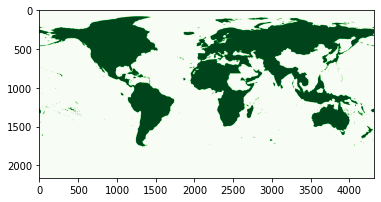

In [53]:
#explore download raster - harvest area fraction
default_pasture_y_2000 = "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_yield_v4.tif"
a = rasterio.open(default_pasture_y_2000)
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Greens')
plt.show()

#### Explore cotton data


In [81]:
cotton_2000_ha_4326 = '../../datasets/raw/crop_data/cotton/cotton_HarvestedAreaFraction.tif'
cotton_2000_y_4326 = '../../datasets/raw/crop_data/cotton/cotton_YieldPerHectare.tif'

EPSG:4326
BoundingBox(left=-180.0, bottom=-90.0, right=179.99999999997954, top=89.99999999998977)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0833333333333286, 0.0, -180.0,
       0.0, -0.0833333333333286, 89.99999999998977), 'blockxsize': 432, 'blockysize': 224, 'tiled': True, 'compress': 'packbits', 'interleave': 'band'}


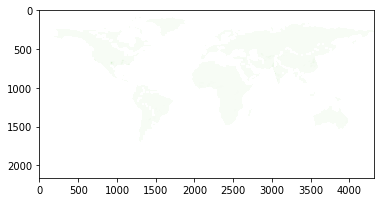

In [82]:
#explore download raster - harvest area fraction
a = rasterio.open(cotton_2000_ha_4326)
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Greens')
plt.show()

EPSG:4326
BoundingBox(left=-180.0, bottom=-90.0, right=179.99999999997954, top=89.99999999998977)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0833333333333286, 0.0, -180.0,
       0.0, -0.0833333333333286, 89.99999999998977), 'blockxsize': 432, 'blockysize': 224, 'tiled': True, 'compress': 'packbits', 'interleave': 'band'}


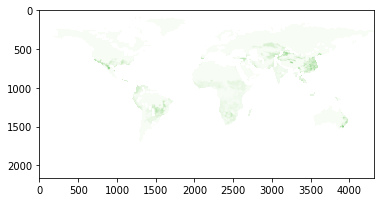

In [83]:
#explore download raster - harvest area fraction
a = rasterio.open(cotton_2000_y_4326)
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Greens')
plt.show()

#### Explore rubber data

In [80]:
rubber_2000_ha_4326 = '../../datasets/raw/crop_data/rubber/rubber_HarvestedAreaFraction.tif'
rubber_2000_y_4326 = '../../datasets/raw/crop_data/rubber/rubber_YieldPerHectare.tif'

EPSG:4326
BoundingBox(left=-180.0, bottom=-90.0, right=179.99999999997954, top=89.99999999998977)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0833333333333286, 0.0, -180.0,
       0.0, -0.0833333333333286, 89.99999999998977), 'blockxsize': 432, 'blockysize': 224, 'tiled': True, 'compress': 'packbits', 'interleave': 'band'}


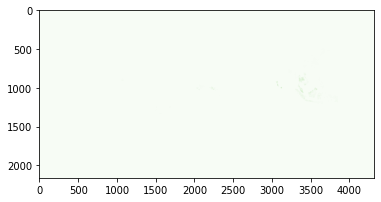

In [84]:
#explore download raster - harvest area fraction
a = rasterio.open(rubber_2000_ha_4326)
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Greens')
plt.show()

EPSG:4326
BoundingBox(left=-180.0, bottom=-90.0, right=179.99999999997954, top=89.99999999998977)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0833333333333286, 0.0, -180.0,
       0.0, -0.0833333333333286, 89.99999999998977), 'blockxsize': 432, 'blockysize': 224, 'tiled': True, 'compress': 'packbits', 'interleave': 'band'}


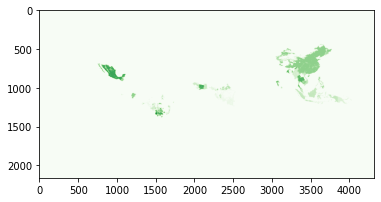

In [85]:
#explore download raster - harvest area fraction
a = rasterio.open(rubber_2000_y_4326)
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Greens')
plt.show()

<a id='risk'></a>
## 3. Generate risk map

<a id='waterRisk'></a>
### 3.1 Unsustainable water use risk

Notes for the unsustainable water risk methodology can be found [here](https://docs.google.com/document/d/1h4BIWMrv6OGRAgNPlOfjOLex_FHb9h22RRTLp00QMzs/edit#). The formula for estimating the unsustianbale water consumption risk(m3/ year) would be:

    Unsustainable water consumption risk (m3 / year) = blue water footprint of one commodity (mm / yr) * harvest area portion in that location (unitless) * 1/1000(unit conversion) 
    
However, as the final impact metric would be dependent on the probability purchase area, for this first iteration we would be estimating alternative the unsustainable water consumption metric withouth this alternative approcah and therefore we will use the following formula to estimate the risk map:

    Unsustainable water consumption risk (m3 / year * Tonnes) = blue water footprint (mm / yr) * harvest area portion in that location * 10000/1000 * 1/ yield (Tonne/ha)
    
Comments and limitations: 

-  very high harvested crop area in one grid-cell and a very low blue water value can result in unrealistically low irrigation volume per hectare.

### 3.1.1 Blue water footprint:
#### Generic blue water footprint:

We can derive the unsustainable water use risk map for rubber from the blue water footprint for specific crops (as can be cotton in our case). However we will need to obtain the blue water footprint for any other crop no covered by the data retreived above (for example rubber). More info can be found [here](http://www.waterfootprint.org/Reports/Report50-NationalWaterFootprints-Vol1.pdf)


In [12]:
# download generic water footprint
url = 'https://data.4tu.nl/articles/dataset/The_green_blue_grey_and_total_water_footprint_related_to_production/12675440'
local_path = '../../datasets/raw/water_indicators/'

#if not os.path.isdir(local_path):
#    os.mkdir(local_path)
#print('Downloading dataset...')
#r = requests.get(url)
#z = zipfile.ZipFile(io.BytesIO(r.content))
#print("Done")
#z.extractall(path=local_path) # extract to folder

In [13]:
!ls ../../datasets/raw/water_indicators/Report50-WF-of-prodn-RasterFiles/wf_totagr_mm

dblbnd.adf  hdr.adf  metadata.xml  prj.adf  sta.adf  w001001.adf  w001001x.adf


In [14]:
default_blwf_1996_2005 = '../../datasets/raw/water_indicators/Report50-WF-of-prodn-RasterFiles/wf_totagr_mm/hdr.adf'

EPSG:4326
BoundingBox(left=-179.99166664999998, bottom=-55.91166665, right=180.00836215000007, top=83.08834447000001)
{'driver': 'AIG', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 4320, 'height': 1668, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.08333334, 0.0, -179.99166664999998,
       0.0, -0.08333334, 83.08834447000001), 'tiled': False}


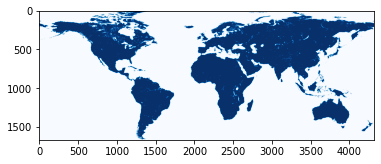

In [15]:
a = rasterio.open(default_blwf_1996_2005)
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Blues')
plt.show()

#### Set the rasters with the global extent:

Before doing the calculations, we should check:

- all the rasters have the same extent
- all the rasters have the same resolution
- the no data in each raster

In [53]:
#change extent in blwf generic data
!gdal_translate -projwin -180.0 90.0 180.0 -90.0 -of GTiff '../../datasets/raw/water_indicators/Report50-WF-of-prodn-RasterFiles/wf_totagr_mm/hdr.adf' '../../datasets/raw/water_indicators/Report50-WF-of-prodn-RasterFiles/wf_totagr_mm/hdr_ext_v2.tif'

Input file size is 4320, 1668
Warning 1: Computed -srcwin -1 -83 4320 2160 falls partially outside raster extent. Going on however.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [55]:
#change extent in default aggricuture harvest area fraction 
!gdal_translate -projwin -180.0 90.0 180.0 -90.0 -of GTiff "../../datasets/raw/crop_data/default_crop/spam2010V2r0_global_H_REST_A.tif" "../../datasets/raw/crop_data/default_crop/spam2010V2r0_global_H_REST_A_ext_v2.tif"

Input file size is 4320, 2160
0...10...20...30...40...50...60...70...80...90...100 - done.


In [57]:
#change extent in default crop yield
!gdal_translate -projwin -180.0 90.0 180.0 -90.0 -of GTiff "../../datasets/raw/crop_data/default_crop/spam2017V2r1_SSA_Y_REST_A.tif" "../../datasets/raw/crop_data/default_crop/spam2017V2r1_SSA_Y_REST_A_ext_v2.tif"

Input file size is 4320, 2160
0...10...20...30...40...50...60...70...80...90...100 - done.


In [58]:
#change extent in default pasture harvest area fraction
!gdal_translate -projwin -180.0 90.0 180.0 -90.0 -of GTiff "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m.tif" "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_ext_v2.tif"  

Input file size is 4320, 2160
0...10...20...30...40...50...60...70...80...90...100 - done.


#### Check global extent reprojection:

In [54]:
default_blwf_1996_2005_ext = '../../datasets/raw/water_indicators/Report50-WF-of-prodn-RasterFiles/wf_totagr_mm/hdr_ext_v2.tif'
default_ag_ha_2010 = "../../datasets/raw/crop_data/default_crop/spam2010V2r0_global_H_REST_A_ext_v2.tif"
default_ag_yield_2010 = "../../datasets/raw/crop_data/default_crop/spam2017V2r1_SSA_Y_REST_A_ext_v2.tif"
default_pasture_ha_2000 = "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_ext_v2.tif"
default_pasture_y_2000 = "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_yield_v4.tif"

EPSG:4326
BoundingBox(left=-180.07499998999998, bottom=-89.99500271000002, right=179.92502881000007, top=90.00501169)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.08333334, 0.0, -180.07499998999998,
       0.0, -0.08333334, 90.00501169), 'tiled': False, 'interleave': 'band'}


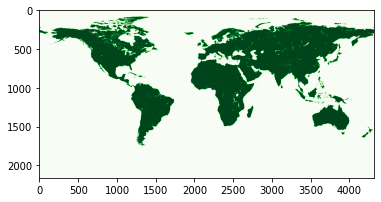

In [60]:
#explore download raster - harvest area fraction
a = rasterio.open(default_blwf_1996_2005_ext)
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Greens')
plt.show()

EPSG:4326
BoundingBox(left=-180.0, bottom=-89.99928, right=179.99856, top=90.0)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1.0, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.083333, 0.0, -180.0,
       0.0, -0.083333, 90.0), 'tiled': False, 'interleave': 'band'}


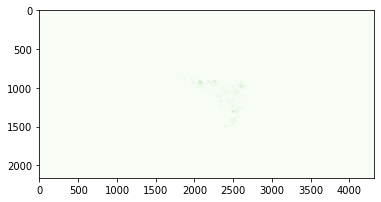

In [61]:
#explore download raster - harvest area fraction
a = rasterio.open(default_ag_yield_2010)
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Greens')
plt.show()

EPSG:4326
BoundingBox(left=-180.0, bottom=-89.99928, right=179.99856, top=90.0)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1.0, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.083333, 0.0, -180.0,
       0.0, -0.083333, 90.0), 'tiled': False, 'interleave': 'band'}


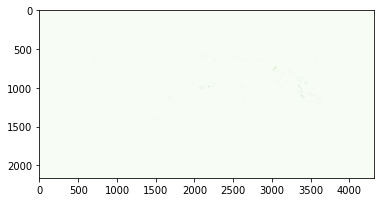

In [62]:
#explore download raster - harvest area fraction
a = rasterio.open(default_ag_ha_2010)
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Greens')
plt.show()

EPSG:4326
BoundingBox(left=-180.0, bottom=-90.0, right=179.99999999997954, top=89.99999999998977)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.402823e+38, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0833333333333286, 0.0, -180.0,
       0.0, -0.0833333333333286, 89.99999999998977), 'tiled': False, 'interleave': 'band'}


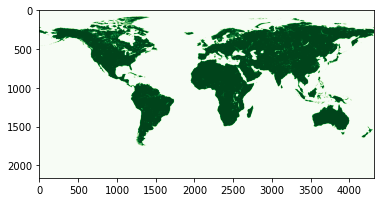

In [63]:
#explore download raster - harvest area fraction
a = rasterio.open(default_pasture_ha_2000)
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Greens')
plt.show()

EPSG:4326
BoundingBox(left=-180.0, bottom=-90.0, right=179.99999999997954, top=89.99999999998977)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.402823e+38, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0833333333333286, 0.0, -180.0,
       0.0, -0.0833333333333286, 89.99999999998977), 'tiled': False, 'interleave': 'band'}


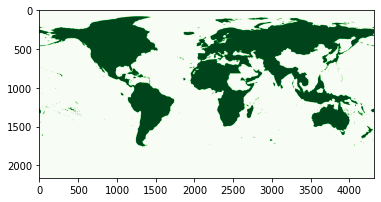

In [55]:
#explore download raster - harvest area fraction
a = rasterio.open(default_pasture_y_2000)
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Greens')
plt.show()

### 3.1.2 Calculate the risk 

For the first version of the mock data, we will produce the risk map without producing the probbility purchase area, using the formula below:

    Unsustainable water consumption (m3 / year * Tonnes) = blue water footprint (mm / yr) * harvest area portion in that location * 10000/1000 * 1/yield (Tonne/ha)
    
Remove 0 values from yiel for calculation as the division produces inf results.

In [29]:
#remove 0 from yield to avoid inf values in default crop
!gdal_calc.py -A "../../datasets/raw/crop_data/default_crop/spam2017V2r1_SSA_Y_REST_A_ext_v2.tif"  --outfile="../../datasets/raw/crop_data/default_crop/spam2017V2r1_SSA_Y_REST_A_ext_v2_NoZero.tif" --calc="A/(A!=0)"

<string>:1: RuntimeWarning: invalid value encountered in true_divide
0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10

EPSG:4326
BoundingBox(left=-180.0, bottom=-89.99928, right=179.99856, top=90.0)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 3.402823466e+38, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.083333, 0.0, -180.0,
       0.0, -0.083333, 90.0), 'tiled': False, 'interleave': 'band'}


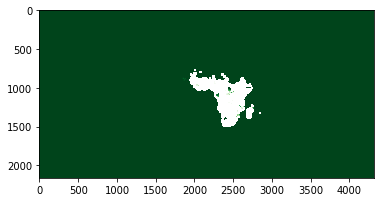

In [30]:
#explore download raster - harvest area fraction
a = rasterio.open("../../datasets/raw/crop_data/default_crop/spam2017V2r1_SSA_Y_REST_A_ext_v2_NoZero.tif")
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Greens')
plt.show()

In [59]:
#remove the zeros to the pasture yield to avoid inf results
!gdal_calc.py -A "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_yield_v4.tif"  --outfile="../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_yield_v5_NoZeros.tif" --calc="A/(A!=0)" --NoDataValue -3.402823e+38 

<string>:1: RuntimeWarning: invalid value encountered in true_divide
0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10

EPSG:4326
BoundingBox(left=-180.0, bottom=-90.0, right=179.99999999997954, top=89.99999999998977)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.402823e+38, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0833333333333286, 0.0, -180.0,
       0.0, -0.0833333333333286, 89.99999999998977), 'tiled': False, 'interleave': 'band'}


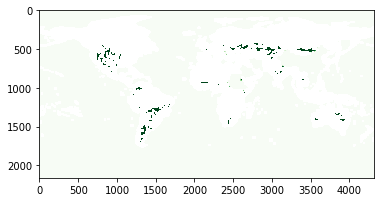

In [60]:
#explore download raster - harvest area fraction
a = rasterio.open("../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_yield_v5_NoZeros.tif")
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Greens')
plt.show()

In [86]:
# remove 0 in cotton to avoid inf results
!gdal_calc.py -A '../../datasets/raw/crop_data/cotton/cotton_YieldPerHectare.tif'  --outfile='../../datasets/raw/crop_data/cotton/cotton_YieldPerHectare_NoZeris.tif' --calc="A/(A!=0)" --NoDataValue -3.402823e+38 

<string>:1: RuntimeWarning: invalid value encountered in true_divide
0.. 1.. 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100 - Done


EPSG:4326
BoundingBox(left=-180.0, bottom=-90.0, right=179.99999999997954, top=89.99999999998977)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.402823e+38, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0833333333333286, 0.0, -180.0,
       0.0, -0.0833333333333286, 89.99999999998977), 'tiled': False, 'interleave': 'band'}


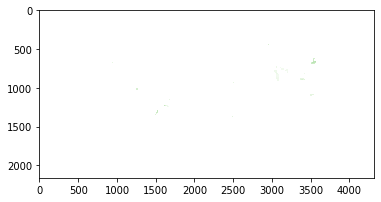

In [87]:
#explore download raster - harvest area fraction
a = rasterio.open('../../datasets/raw/crop_data/cotton/cotton_YieldPerHectare_NoZeris.tif')
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Greens')
plt.show()

In [88]:
# remove 0 in rubber to avoid inf results
!gdal_calc.py -A '../../datasets/raw/crop_data/rubber/rubber_YieldPerHectare.tif'  --outfile='../../datasets/raw/crop_data/rubber/rubber_YieldPerHectare_NoZeros.tif' --calc="A/(A!=0)" --NoDataValue -3.402823e+38 

<string>:1: RuntimeWarning: invalid value encountered in true_divide
0.. 1.. 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100 - Done


EPSG:4326
BoundingBox(left=-180.0, bottom=-90.0, right=179.99999999997954, top=89.99999999998977)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.402823e+38, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0833333333333286, 0.0, -180.0,
       0.0, -0.0833333333333286, 89.99999999998977), 'tiled': False, 'interleave': 'band'}


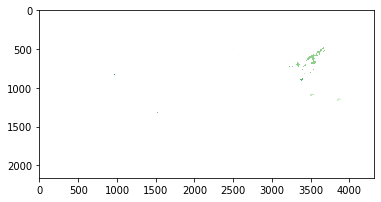

In [89]:
#explore download raster - harvest area fraction
a = rasterio.open('../../datasets/raw/crop_data/rubber/rubber_YieldPerHectare_NoZeros.tif')
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Greens')
plt.show()

In [90]:
default_blwf_1996_2005_ext = '../../datasets/raw/water_indicators/Report50-WF-of-prodn-RasterFiles/wf_totagr_mm/hdr_ext_v2.tif'
default_ag_ha_2010 = "../../datasets/raw/crop_data/default_crop/spam2010V2r0_global_H_REST_A_ext_v2.tif"
default_ag_yield_2010 = "../../datasets/raw/crop_data/default_crop/spam2017V2r1_SSA_Y_REST_A_ext_v2_NoZero.tif" 
default_pasture_ha_2000 = "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_ext_v2.tif"
default_pasture_y_2000 = "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_yield_v5_NoZeros.tif"
cotton_y_2000 = '../../datasets/raw/crop_data/cotton/cotton_YieldPerHectare_NoZeris.tif'
cotton_ha_2000 = '../../datasets/raw/crop_data/cotton/cotton_HarvestedAreaFraction.tif'
rubber_y_2000 = '../../datasets/raw/crop_data/rubber/rubber_YieldPerHectare_NoZeros.tif'
rubber_ha_2000 = '../../datasets/raw/crop_data/rubber/rubber_HarvestedAreaFraction.tif'

#### Default unsustianbale water risk for aggricultural:

In [32]:
#CALCULATE DEFAULT AGRICULTURAL RISK
!gdal_calc.py -A $default_blwf_1996_2005_ext -B $default_ag_ha_2010 -C $default_ag_yield_2010 --outfile='../../datasets/processed/water_indicators/water_risk_4323_2010_v2.tif' --calc="A *B*(1/C)*(10000/1000)"

<string>:1: RuntimeWarning: overflow encountered in multiply
/opt/conda/lib/python3.8/site-packages/osgeo/utils/gdal_calc.py:367: RuntimeWarning: invalid value encountered in multiply
  myResult = ((1 * (myNDVs == 0)) * myResult) + (myOutNDV * myNDVs)
0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 

EPSG:4326
BoundingBox(left=-180.07499998999998, bottom=-89.99500271000002, right=179.92502881000007, top=90.00501169)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 3.402823466e+38, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.08333334, 0.0, -180.07499998999998,
       0.0, -0.08333334, 90.00501169), 'tiled': False, 'interleave': 'band'}


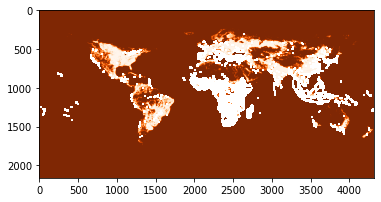

In [63]:
#explore default aggricultural risk map
default_aggri_risk_2010 = "../../datasets/processed/water_indicators/water_risk_aggriculture_4326_2010_v2.tif"
a = rasterio.open(default_aggri_risk_2010)
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Oranges')
plt.show()

####  Default unsustianbale water risk for pasture:


In [62]:
## the results from gdal cal produce inf results
!gdal_calc.py -A $default_blwf_1996_2005_ext -B $default_pasture_ha_2000 -C $default_pasture_y_2000 --outfile='../../datasets/processed/water_indicators/water_risk_pasture_4326_2000_v9.tif' --calc="A*B*(1/C)*(10000/1000)" --NoDataValue -3.402823e+38 

<string>:1: RuntimeWarning: overflow encountered in multiply
/opt/conda/lib/python3.8/site-packages/osgeo/utils/gdal_calc.py:367: RuntimeWarning: invalid value encountered in multiply
  myResult = ((1 * (myNDVs == 0)) * myResult) + (myOutNDV * myNDVs)
0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 

#### NOTE:

I'm having issue runing the gdal calculator for the pasture risk. TO that end I'll use the raster calculator from qgis to produce the pasture risk map.

EPSG:4326
BoundingBox(left=-180.075, bottom=-89.995, right=179.92503, top=90.00501)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.08333334027777778, 0.0, -180.075,
       0.0, -0.08333333796296297, 90.00501), 'tiled': False, 'interleave': 'band'}


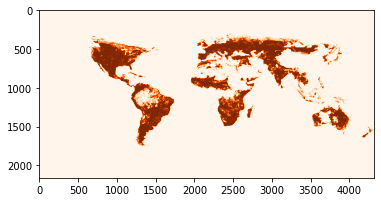

In [64]:
#explore default pasture risk map
default_pasture_risk_2000 = "../../datasets/processed/water_indicators/water_risk_pasture_4326_2000_v10.tif"
a = rasterio.open(default_pasture_risk_2000)
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Oranges')
plt.show()

#### Water risk for cotton:

In [91]:
#calculate global water risk for cotton in 2000
!gdal_calc.py -A $default_blwf_1996_2005_ext -B $cotton_ha_2000 -C $cotton_y_2000 --outfile='../../datasets/processed/water_indicators/water_risk_cotton_4326_2000.tif' --calc="A *B*(1/C)*(10000/1000)"

<string>:1: RuntimeWarning: overflow encountered in multiply
/opt/conda/lib/python3.8/site-packages/osgeo/utils/gdal_calc.py:367: RuntimeWarning: invalid value encountered in multiply
  myResult = ((1 * (myNDVs == 0)) * myResult) + (myOutNDV * myNDVs)
0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 

EPSG:4326
BoundingBox(left=-180.07499998999998, bottom=-89.99500271000002, right=179.92502881000007, top=90.00501169)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 3.402823466e+38, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.08333334, 0.0, -180.07499998999998,
       0.0, -0.08333334, 90.00501169), 'tiled': False, 'interleave': 'band'}


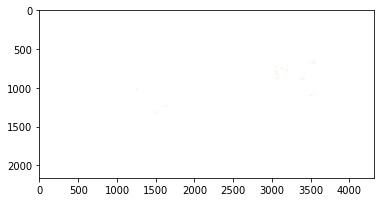

In [92]:
#explore default pasture risk map
a = rasterio.open('../../datasets/processed/water_indicators/water_risk_cotton_4326_2000.tif')
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Oranges')
plt.show()

#### Water risk for rubber:

In [93]:
#calculate global water risk for rubber in 2000
!gdal_calc.py -A $default_blwf_1996_2005_ext -B $rubber_ha_2000 -C $rubber_y_2000 --outfile='../../datasets/processed/water_indicators/water_risk_rubber_4326_2000.tif' --calc="A *B*(1/C)*(10000/1000)"

<string>:1: RuntimeWarning: overflow encountered in multiply
/opt/conda/lib/python3.8/site-packages/osgeo/utils/gdal_calc.py:367: RuntimeWarning: invalid value encountered in multiply
  myResult = ((1 * (myNDVs == 0)) * myResult) + (myOutNDV * myNDVs)
0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 

EPSG:4326
BoundingBox(left=-180.07499998999998, bottom=-89.99500271000002, right=179.92502881000007, top=90.00501169)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 3.402823466e+38, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.08333334, 0.0, -180.07499998999998,
       0.0, -0.08333334, 90.00501169), 'tiled': False, 'interleave': 'band'}


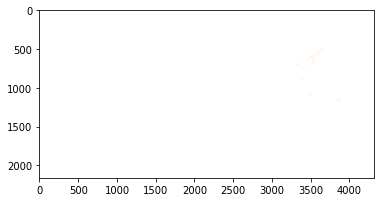

In [94]:
#explore default pasture risk map
a = rasterio.open('../../datasets/processed/water_indicators/water_risk_rubber_4326_2000.tif')
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Oranges')
plt.show()

<a id='deforestationRisk'></a>
### 3.2 Deforestation risk

Notes for the deforestation risk methodology can be found [here](https://docs.google.com/document/d/16XoklY3Ze2LQRMuiignE7fPURIB0a1llZHEzzRy2fWU/edit#heading=h.g8tlcpcbnmgq). The formula for estimating the deforestation risk(ha/ year) would be:

    Deforestation area due to commodity (ha/year) = Total deforestation area (ha) * Purchase area fraction (unitless)

    
However, as the final impact metric would be dependent on the probability purchase area, for this first iteration we would be estimating alternative the deforestation metric withouth this alternative approcah and therefore we will use the following formula to estimate the risk map:

    Deforestation area due to commodity (ha/year *tonnes) = Total deforestation area (ha) *  1/ yield (Tonne/ha) * 0.0001

NOTE: For calculating this first mock data we will use the deforestation stimations from [our world in data](https://ourworldindata.org/deforestation)



#### Calculate total deforestation in ha

In [68]:
##open the csv 
deforestation = gpd.read_file('../../datasets/raw/deforestation_indicators/annual-change-forest-area.csv')
deforestation.head()

,Entity,Code,Year,Net forest conversion,geometry
0,Algeria,DZA,1990,-8800,None
1,Algeria,DZA,2000,33900,None
2,Algeria,DZA,2010,7600,None
3,Algeria,DZA,2015,-1400.0000000000005,None
4,Argentina,ARG,1990,-182600,None


In [71]:
#filter those whose year is 2000
deforestation = deforestation[deforestation['Year']=='2000']
deforestation.head()

,Entity,Code,Year,Net forest conversion,geometry
1,Algeria,DZA,2000,33900,None
5,Argentina,ARG,2000,-316400,None
9,Aruba,ABW,2000,0,None
13,Australia,AUS,2000,-226799.99999999994,None
16,Austria,AUT,2000,2510.0000000000005,None


In [73]:
deforestation_ha_list = []
for i, row in default_pasture_yield_2000.iterrows():
    location = row['Area']
    try:
        deforestation_ha = deforestation[deforestation['Entity']==location].iloc[0]['Net forest conversion']    
    except:
        deforestation_ha = 0
    deforestation_ha_list.append(deforestation_ha)
    
##append to main geodataframe
default_pasture_yield_2000['deforestation_ha'] = deforestation_ha_list
default_pasture_yield_2000.head()

,Domain Cod,Domain,Area Code,Area,Element Co,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Descr,geometry,animal_ha,yield_t_ha,deforestation_ha
0,QL,Livestock Primary,2,Afghanistan,5420,Yield,919,"Hides, cattle, fresh",2000,2000,hg/An,295,Fc,Calculated data,"POLYGON ((60.51760 34.06176, 60.51934 34.06627...",0.05,0.001475,0
1,QL,Livestock Primary,3,Albania,5420,Yield,919,"Hides, cattle, fresh",2000,2000,hg/An,219,Fc,Calculated data,"POLYGON ((19.00099 40.50217, 19.00099 40.50396...",0.38,0.008322,0
2,QL,Livestock Primary,4,Algeria,5420,Yield,919,"Hides, cattle, fresh",2000,2000,hg/An,240,Fc,Calculated data,"POLYGON ((-8.66891 28.24094, -8.66891 28.30392...",0.03,0.000720,33900
3,QL,Livestock Primary,7,Angola,5420,Yield,919,"Hides, cattle, fresh",2000,2000,hg/An,285,Fc,Calculated data,"MULTIPOLYGON (((11.46098 -16.55432, 11.46166 -...",0.04,0.001140,0
4,QL,Livestock Primary,8,Antigua and Barbuda,5420,Yield,919,"Hides, cattle, fresh",2000,2000,hg/An,224,Fc,Calculated data,"MULTIPOLYGON (((-62.55365 16.89931, -62.51644 ...",0.88,0.019712,0


In [95]:
# save file 
default_pasture_yield_2000.to_file("../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_yield.shp", driver='ESRI Shapefile')

<ipython-input-95-36214e1729bc>:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  default_pasture_yield_2000.to_file("../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_yield.shp", driver='ESRI Shapefile')


In [98]:
# rasterise to the same resolution
#convert file to raster with same extent and resolution that the pasture harvset area
!gdal_rasterize -l Pasture2000_5m_yield -a deforestat -tr 0.083333 0.083333 -a_nodata 0.0 -te -180.0 -90.0 180.0 90.0 -ot Float32 -of GTiff "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_yield.shp" "../../datasets/raw/deforestation_indicators/global_deforestation_2000_ha_4326.tif"

0...10...20...30...40...50...60...70...80...90...100 - done.


In [99]:
#set projection to dataset
!gdal_edit.py -a_srs EPSG:4326 "../../datasets/raw/deforestation_indicators/global_deforestation_2000_ha_4326.tif"

#### Assing that deforestation to the different commodities:

We will assign the deforestation to each commodity based on the area fraction in each location:

    deforestation_commodity = total_deforestation * commodity_harvest_area_fraction
    
#### cotton deforestation risk:


In [ ]:
default_blwf_1996_2005_ext = '../../datasets/raw/water_indicators/Report50-WF-of-prodn-RasterFiles/wf_totagr_mm/hdr_ext_v2.tif'
default_ag_ha_2010 = "../../datasets/raw/crop_data/default_crop/spam2010V2r0_global_H_REST_A_ext_v2.tif"
default_ag_yield_2010 = "../../datasets/raw/crop_data/default_crop/spam2017V2r1_SSA_Y_REST_A_ext_v2_NoZero.tif" 
default_pasture_ha_2000 = "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_ext_v2.tif"
default_pasture_y_2000 = "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_yield_v5_NoZeros.tif"
cotton_y_2000 = '../../datasets/raw/crop_data/cotton/cotton_YieldPerHectare_NoZeris.tif'
cotton_ha_2000 = '../../datasets/raw/crop_data/cotton/cotton_HarvestedAreaFraction.tif'
rubber_y_2000 = '../../datasets/raw/crop_data/rubber/rubber_YieldPerHectare_NoZeros.tif'
rubber_ha_2000 = '../../datasets/raw/crop_data/rubber/rubber_HarvestedAreaFraction.tif'

In [9]:
total_deforestation = "../../datasets/raw/deforestation_indicators/global_deforestation_2000_ha_4326.tif"

In [103]:
!ls ../../datasets/processed/deforestation_indicators

deforestation_metric_ha_2018_3857_test_location.tif
deforestation_metric_ha_2018_3857_test_location.tif.aux.xml
deforestation_risk_ha_2018_new_extent_3857.tif
deforestation_risk_ha_2018_new_extent.tif
deforestation_risk_ha_2018_new_xxtent_bio.tif
deforestation_risk_ha_2018.tif
deforestation_risk_ha_2018.tif.aux.xml


In [105]:
#calculate global cotton deforestation risk in 2000
!gdal_calc.py -A $total_deforestation -B $cotton_ha_2000 -C $cotton_y_2000 --outfile='../../datasets/processed/deforestation_indicators/deforestation_risk_cotton_4326_2000.tif' --calc="A*B *(1/C)*0.0001"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 1

EPSG:4326
BoundingBox(left=-180.0, bottom=-89.99928, right=179.99856, top=90.0)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 3.402823466e+38, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.083333, 0.0, -180.0,
       0.0, -0.083333, 90.0), 'tiled': False, 'interleave': 'band'}


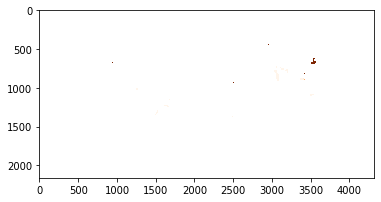

In [106]:
#explore default cotton risk map
a = rasterio.open('../../datasets/processed/deforestation_indicators/deforestation_risk_cotton_4326_2000.tif')
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Oranges')
plt.show()

#### rubber deforestation risk:

In [107]:
#calculate global cotton deforestation risk in 2000
!gdal_calc.py -A $total_deforestation -B $rubber_ha_2000 -C $rubber_y_2000 --outfile='../../datasets/processed/deforestation_indicators/deforestation_risk_rubber_4326_2000.tif' --calc="A*B *(1/C)*0.0001"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 1

EPSG:4326
BoundingBox(left=-180.0, bottom=-89.99928, right=179.99856, top=90.0)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 3.402823466e+38, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.083333, 0.0, -180.0,
       0.0, -0.083333, 90.0), 'tiled': False, 'interleave': 'band'}


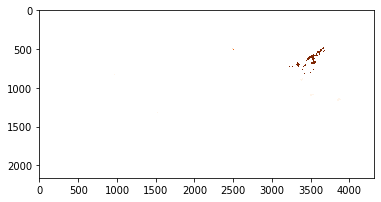

In [108]:
#explore default rubber risk map
a = rasterio.open('../../datasets/processed/deforestation_indicators/deforestation_risk_rubber_4326_2000.tif')
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Oranges')
plt.show()

#### pasture deforestation risk:

For doing the operations with gdal we need to remove the no data from the pasture harvest area and yield datasets

In [1]:
!gdal_translate -a_nodata 0.0 -of GTiff "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_ext_v2.tif" "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_ext_v2_0_nd.tif"

Input file size is 4320, 2160
0...10...20...30...40...50...60...70...80...90...100 - done.


In [2]:
!gdal_translate -a_nodata 0.0 -of GTiff "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_yield_v5_NoZeros.tif" "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_yield_v5_NoZeros_0_nd.tif"

Input file size is 4320, 2160
0...10...20...30...40...50...60...70...80...90...100 - done.


In [3]:
!gdal_calc.py --calc "A*(A>-3.40282e+38)" --format GTiff --type Float32 --NoDataValue 0.0 -A "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_ext_v2_0_nd.tif" --A_band 1 --outfile "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_ext_v2_NoData.tif"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 1

In [4]:
!gdal_calc.py --calc "A*(A>-3.40282e+38)" --format GTiff --type Float32 --NoDataValue 0.0 -A "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_yield_v5_NoZeros_0_nd.tif" --A_band 1 --outfile "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_yield_v5_NoZeros_NoData.tif"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 1

In [10]:
#calculate global cotton deforestation risk in 2000
!gdal_calc.py -A $total_deforestation -B "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_ext_v2_NoData.tif" -C "../../datasets/raw/crop_data/default_pasture/CroplandPastureArea2000_Geotiff/Pasture2000_5m_yield_v5_NoZeros_NoData.tif" --outfile='../../datasets/processed/deforestation_indicators/deforestation_risk_pasture_4326_2000_v2.tif' --calc="A*B*(1/C)*0.0001"

<string>:1: RuntimeWarning: divide by zero encountered in true_divide
<string>:1: RuntimeWarning: invalid value encountered in multiply
/opt/conda/lib/python3.8/site-packages/osgeo/utils/gdal_calc.py:367: RuntimeWarning: invalid value encountered in multiply
  myResult = ((1 * (myNDVs == 0)) * myResult) + (myOutNDV * myNDVs)
0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7

EPSG:4326
BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.08333333333333333, 0.0, -180.0,
       0.0, -0.08333333333333333, 90.0), 'tiled': False, 'interleave': 'band'}


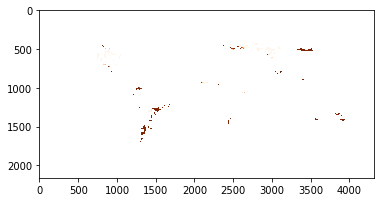

In [15]:
#explore default pasture risk map
a = rasterio.open('../../datasets/processed/deforestation_indicators/deforestation_risk_pasture_4326_2000_v2.tif')
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Oranges')
plt.show()

#### NOTE: 

- check deforestation risk in qgis

<a id='carbonRisk'></a>
### 3.3 Carbon emissions due to land use change risk

Notes for the carbon risk methodology can be found [here](https://docs.google.com/document/d/19D1WKgLqVelLlG98aHHoYxhaj6VJHH4bcRTPY33HmJ8/edit#). The formula for estimating the carbon emission risk due to land use change (tCO2/ year) would be:

    Carbon emissions due to land use change (tCO2e / year)  =  total tree cover area lost (Hectare) * Net forest GHG flux - 2001-2020 (tCO₂e / Hectare) * 10000/19 (unit conversion) *   probability purchase area (unitless) 

    
However, as the final impact metric would be dependent on the probability purchase area, for this first iteration we would be estimating alternative the deforestation metric withouth this alternative approcah and therefore we will use the following formula to estimate the risk map:

    Carbon emissions due to land use change (tCO2e / year *tonne) = deforestation risk (ha/year * tonne) * Net forest GHG flux - 2001-2020 (tCO₂e / Hectare) * 10000/19 (unit conversion)

NOTE: For calculating this first mock data we will be using, temporarily, [the carbon emissions estimations from earthstat.](http://www.earthstat.org/greenhouse-gas-emissions-croplands/)

#### Exploring carbon emissions

The carbon emissions dataset exploration has been done in the notebooj 4_carbon_indicator_v2. 

In [20]:
total_carbon_emissions_2000 = '../../datasets/raw/carbon_indicators/GHGEmissions_Geotiff/total_emissions.tif'
cotton_deforestation_risk_2000 = '../../datasets/processed/deforestation_indicators/deforestation_risk_cotton_4326_2000.tif'
rubber_deforestation_risk_2000 = '../../datasets/processed/deforestation_indicators/deforestation_risk_rubber_4326_2000.tif'
pasture_deforestation_risk_2000 = '../../datasets/processed/deforestation_indicators/deforestation_risk_pasture_4326_2000.tif'

EPSG:4326
BoundingBox(left=-180.0, bottom=-90.0, right=179.99999999997954, top=89.99999999998977)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0833333333333286, 0.0, -180.0,
       0.0, -0.0833333333333286, 89.99999999998977), 'blockxsize': 432, 'blockysize': 224, 'tiled': True, 'compress': 'packbits', 'interleave': 'band'}


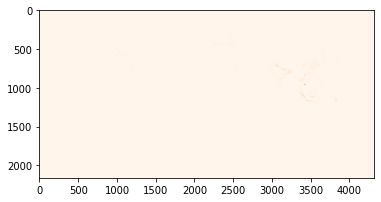

In [5]:
#explore default pasture risk map
a = rasterio.open(total_carbon_emissions_2000)
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Oranges')
plt.show()

#### Cotton emissions due to land use change risk:

As we have no data vlues for the deforestation risk dataset, we need to set those to 0 in order to compute the emissions risk and remove the inf values ffrom the result dataset. For that we will do the following:

- translate deforestation dataset with gdal to set no data values to 0
- gdal calc to get the deforestation risk dataset with no data values
- produce the final calculation

In [21]:
!gdal_translate -a_nodata 0.0 -of GTiff '../../datasets/processed/deforestation_indicators/deforestation_risk_cotton_4326_2000.tif' '../../datasets/processed/deforestation_indicators/deforestation_risk_cotton_4326_2000_0_nd.tif'

Input file size is 4320, 2160
0...10...20...30...40...50...60...70...80...90...100 - done.


In [22]:
!gdal_calc.py --calc "A*(A<3.40282e+38)" --format GTiff --type Float32 --NoDataValue 0.0 -A '../../datasets/processed/deforestation_indicators/deforestation_risk_cotton_4326_2000_0_nd.tif' --A_band 1 --outfile '../../datasets/processed/deforestation_indicators/deforestation_risk_cotton_4326_2000_NoData.tif'

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 1

In [23]:
#calculate global cotton deforestation risk in 2000
!gdal_calc.py -A $total_carbon_emissions_2000 -B '../../datasets/processed/deforestation_indicators/deforestation_risk_cotton_4326_2000_NoData.tif' --outfile='../../datasets/processed/carbon_indicators/carbon_emissions_risk_cotton_4326_2000.tif' --calc="A*B"

0.. 1.. 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100 - Done


EPSG:4326
BoundingBox(left=-180.0, bottom=-90.0, right=179.99999999997954, top=89.99999999998977)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 3.402823466e+38, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0833333333333286, 0.0, -180.0,
       0.0, -0.0833333333333286, 89.99999999998977), 'tiled': False, 'interleave': 'band'}


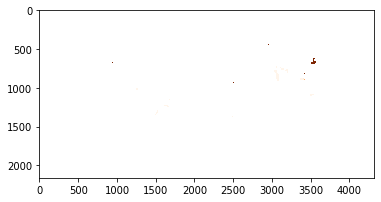

In [24]:
#explore default pasture risk map
a = rasterio.open('../../datasets/processed/carbon_indicators/carbon_emissions_risk_cotton_4326_2000.tif')
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Oranges')
plt.show()

#### Rubber emissions due to land use change risk:

We will do the same for the rubber and pasture.

In [25]:
!gdal_translate -a_nodata 0.0 -of GTiff '../../datasets/processed/deforestation_indicators/deforestation_risk_rubber_4326_2000.tif' '../../datasets/processed/deforestation_indicators/deforestation_risk_rubber_4326_2000_0_nd.tif'

Input file size is 4320, 2160
0...10...20...30...40...50...60...70...80...90...100 - done.


In [26]:
!gdal_calc.py --calc "A*(A<3.40282e+38)" --format GTiff --type Float32 --NoDataValue 0.0 -A '../../datasets/processed/deforestation_indicators/deforestation_risk_rubber_4326_2000_0_nd.tif' --A_band 1 --outfile '../../datasets/processed/deforestation_indicators/deforestation_risk_rubber_4326_2000_NoData.tif'

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 1

In [27]:
#calculate global cotton deforestation risk in 2000
!gdal_calc.py -A $total_carbon_emissions_2000 -B '../../datasets/processed/deforestation_indicators/deforestation_risk_rubber_4326_2000_NoData.tif' --outfile='../../datasets/processed/carbon_indicators/carbon_emissions_risk_rubber_4326_2000.tif' --calc="A*B"

0.. 1.. 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100 - Done


EPSG:4326
BoundingBox(left=-180.0, bottom=-90.0, right=179.99999999997954, top=89.99999999998977)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 3.402823466e+38, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0833333333333286, 0.0, -180.0,
       0.0, -0.0833333333333286, 89.99999999998977), 'tiled': False, 'interleave': 'band'}


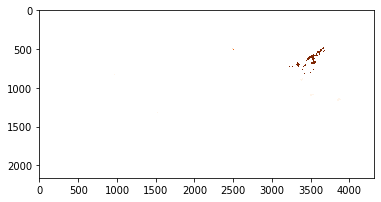

In [28]:
#explore default pasture risk map
a = rasterio.open('../../datasets/processed/carbon_indicators/carbon_emissions_risk_rubber_4326_2000.tif')
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Oranges')
plt.show()

#### Pasture emissions due to land use change risk:

In [16]:
!gdal_translate -a_nodata 0.0 -of GTiff '../../datasets/processed/deforestation_indicators/deforestation_risk_pasture_4326_2000_v2.tif' '../../datasets/processed/deforestation_indicators/deforestation_risk_pasture_4326_2000_v2_0_nd_v2.tif'

Input file size is 4320, 2160
0...10...20...30...40...50...60...70...80...90...100 - done.


In [18]:
!gdal_calc.py --calc "A*(A>-3.40282e+38)" --format GTiff --type Float32 --NoDataValue 0.0 -A '../../datasets/processed/deforestation_indicators/deforestation_risk_pasture_4326_2000_v2_0_nd_v2.tif' --A_band 1 --outfile '../../datasets/processed/deforestation_indicators/deforestation_risk_pasture_4326_2000_NoData_v2.tif'

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 1

In [21]:
!gdal_calc.py -A $total_carbon_emissions_2000 -B '../../datasets/processed/deforestation_indicators/deforestation_risk_pasture_4326_2000_NoData_v2.tif' --outfile='../../datasets/processed/carbon_indicators/carbon_emissions_risk_pasture_4326_2000_v2.tif' --calc="A*B"

0.. 1.. 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100 - Done


EPSG:4326
BoundingBox(left=-180.0, bottom=-90.0, right=179.99999999997954, top=89.99999999998977)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 3.402823466e+38, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0833333333333286, 0.0, -180.0,
       0.0, -0.0833333333333286, 89.99999999998977), 'tiled': False, 'interleave': 'band'}


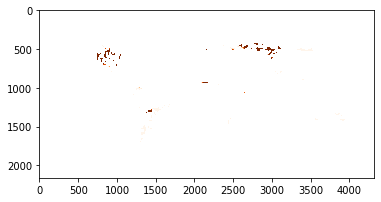

In [22]:
#explore default pasture risk map
a = rasterio.open('../../datasets/processed/carbon_indicators/carbon_emissions_risk_pasture_4326_2000_v2.tif')
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Oranges')
plt.show()

<a id='biodiversityRisk'></a>
### 3.4 Biodiverstity loss due to land use change risk

Notes for the iodiversity risk due to land use change methodology can be found [here](https://docs.google.com/document/d/1MqkKVFG5jZkAMGh3ZZHROhhc6y4PA11l8qysI1cSjF0/edit#). The formula for estimating the biodiversity risk due to land use change (PDF / year) would be:

    Biodiversity loss due to land use change (PDF / year) =  = area with tree cover loss and land use change (hectares) * taxa-aggregated characterization factors for Regional Potential Species Loss (PSL) (PDF / year * m2) *   (1/ 0.0001) (conversion units) *  probability purchase area (unitless) 

    
However, as the final impact metric would be dependent on the probability purchase area, for this first iteration we would be estimating alternative the deforestation metric withouth this alternative approcah and therefore we will use the following formula to estimate the risk map:

    Biodiversity loss due to land use change (PDF / year *tonnes) = deforestation risk (ha/year * tonne) *taxa-aggregated characterization factors for Regional Potential Species Loss (PSL) (PDF / year * m2) *   (1/ 0.0001) (conversion units)
    

#### Exploring cotton biodiversity impact due to land use change

The carbon emissions dataset exploration has been done in the notebook 1_biodiversity_indicator. 

In [24]:
taxa_cf_2000 = '../../datasets/processed/biodiversity_indicators/taxa_aggregated_characterization_factors_4326.tif'

EPSG:4326
BoundingBox(left=-180.0, bottom=-89.99999999998977, right=179.99999999997954, top=90.0)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0833333333333286, 0.0, -180.0,
       0.0, -0.0833333333333286, 90.0), 'tiled': False, 'interleave': 'band'}


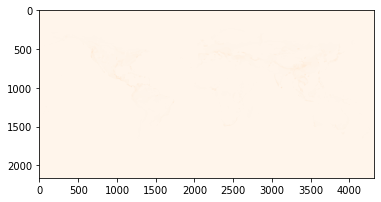

In [34]:
a = rasterio.open(taxa_cf_2000)
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Oranges')
plt.show()

In [35]:
!gdal_calc.py -A $taxa_cf_2000 -B '../../datasets/processed/deforestation_indicators/deforestation_risk_cotton_4326_2000_NoData.tif' --outfile='../../datasets/processed/biodiversity_indicators/biodiversity_loss_risk_cotton_4326_2000.tif' --calc="A*B*(1/ 0.0001)"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 1

EPSG:4326
BoundingBox(left=-180.0, bottom=-89.99999999998977, right=179.99999999997954, top=90.0)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 3.402823466e+38, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0833333333333286, 0.0, -180.0,
       0.0, -0.0833333333333286, 90.0), 'tiled': False, 'interleave': 'band'}


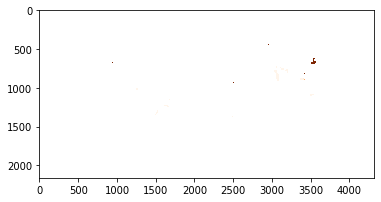

In [36]:
a = rasterio.open('../../datasets/processed/biodiversity_indicators/biodiversity_loss_risk_cotton_4326_2000.tif')
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Oranges')
plt.show()

#### Exploring rubber biodiversity impact due to land use change

In [37]:
!gdal_calc.py -A $taxa_cf_2000 -B '../../datasets/processed/deforestation_indicators/deforestation_risk_rubber_4326_2000_NoData.tif' --outfile='../../datasets/processed/biodiversity_indicators/biodiversity_loss_risk_rubber_4326_2000.tif' --calc="A*B*(1/ 0.0001)"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 1

EPSG:4326
BoundingBox(left=-180.0, bottom=-89.99999999998977, right=179.99999999997954, top=90.0)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 3.402823466e+38, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0833333333333286, 0.0, -180.0,
       0.0, -0.0833333333333286, 90.0), 'tiled': False, 'interleave': 'band'}


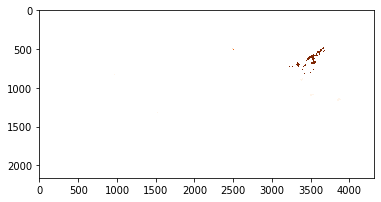

In [38]:
a = rasterio.open('../../datasets/processed/biodiversity_indicators/biodiversity_loss_risk_rubber_4326_2000.tif')
print(a.crs)
print(a.bounds)
print(a.profile)
plt.imshow(a.read(1), cmap='Oranges')
plt.show()

#### Exploring rubber biodiversity impact due to land use change

In [25]:
!gdal_calc.py -A $taxa_cf_2000 -B '../../datasets/processed/deforestation_indicators/deforestation_risk_pasture_4326_2000_NoData_v2.tif' --outfile='../../datasets/processed/biodiversity_indicators/biodiversity_loss_risk_pasture_4326_2000_v2.tif' --calc="A*B*(1/ 0.0001)"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 1

<a id='metric'></a>
## 4. Get metrics for user data

Do the zonal stats on the geometries.

In [51]:
## ruber
rubber_water_risk = '../../datasets/processed/water_indicators/water_risk_rubber_4326_2000_v2.tif'
rubber_deforestation_risk = '../../datasets/processed/deforestation_indicators/deforestation_risk_rubber_4326_2000_NoData.tif'
rubber_carbon_risk = '../../datasets/processed/carbon_indicators/carbon_emissions_risk_rubber_4326_2000_v2.tif'
rubber_biodiversity_risk = '../../datasets/processed/biodiversity_indicators/biodiversity_loss_risk_rubber_4326_2000_v2.tif'

# cotton
cotton_water_risk = '../../datasets/processed/water_indicators/water_risk_cotton_4326_2000_v2.tif'
cotton_deforestation_risk = '../../datasets/processed/deforestation_indicators/deforestation_risk_cotton_4326_2000_NoData.tif'
cotton_carbon_risk = '../../datasets/processed/carbon_indicators/carbon_emissions_risk_cotton_4326_2000_v2.tif'
cotton_biodiversity_risk = '../../datasets/processed/biodiversity_indicators/biodiversity_loss_risk_cotton_4326_2000_v2.tif'

# pasture
pasture_water_risk = "../../datasets/processed/water_indicators/water_risk_pasture_4326_2000_v11.tif"
pasture_deforestation_risk = '../../datasets/processed/deforestation_indicators/deforestation_risk_pasture_4326_2000_NoData_v2.tif'
pasture_carbon_risk = '../../datasets/processed/carbon_indicators/carbon_emissions_risk_pasture_4326_2000_v3.tif'
pasture_biodiversity_risk = '../../datasets/processed/biodiversity_indicators/biodiversity_loss_risk_pasture_4326_2000_v3.tif'

In [52]:
supply_data.head()

,Material,Material d,Volume,Country,Address,Latitude,Longitude,Location t,Accuracy,geometry,...,cr_mean,cr_median,cr_std,cr_min,cr_max,bio_mean,bio_median,bio_std,bio_min,bio_max
0,Rubber,None,2400,China,None,None,None,Unknown,Low,"MULTIPOLYGON (((73.49973 39.38174, 73.50468 39...",...,inf,inf,NaN,2.813154e-08,3.402823e+38,inf,inf,NaN,1.384501e-14,3.402823e+38
1,Rubber,None,1300,Malaysia,None,None,None,Unknown,Low,"MULTIPOLYGON (((98.93721 5.68384, 98.93771 5.6...",...,inf,inf,NaN,3.402823e+38,3.402823e+38,inf,inf,NaN,3.402823e+38,3.402823e+38
2,Rubber,None,1000,United States,None,None,None,Unknown,Low,"MULTIPOLYGON (((-180.00000 51.79409, -180.0000...",...,inf,3.402823e+38,NaN,3.402823e+38,3.402823e+38,inf,3.402823e+38,NaN,3.402823e+38,3.402823e+38
3,Rubber,None,730,Japan,None,None,None,Unknown,Low,"MULTIPOLYGON (((122.71418 24.44983, 122.71457 ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Rubber,None,490,India,None,None,None,Unknown,Low,"MULTIPOLYGON (((68.11138 23.60145, 68.13528 23...",...,inf,3.201923e+01,NaN,-2.434870e+02,3.402823e+38,inf,4.421980e-10,NaN,-5.642628e-10,3.402823e+38


In [53]:
#water risk
water_risk_mean_list = []
water_risk_median_list = []
water_risk_std_list = []
water_risk_max_list = []
water_risk_min_list = []

#deforestation risk
deforestation_risk_mean_list = []
deforestation_risk_median_list = []
deforestation_risk_std_list = []
deforestation_risk_max_list = []
deforestation_risk_min_list = []

#carbon risk
carbon_risk_mean_list = []
carbon_risk_median_list = []
carbon_risk_std_list = []
carbon_risk_max_list = []
carbon_risk_min_list = []

#biodiversity risk
biodiversity_risk_mean_list = []
biodiversity_risk_median_list = []
biodiversity_risk_std_list = []
biodiversity_risk_max_list = []
biodiversity_risk_min_list = []

start_time = time.time()
for i, row in supply_data.iterrows():
    material = row['Material']
    geom = row['geometry']

    if material == 'Rubber':
        #calculate risk for water
        water_stats = zonal_stats(geom, rubber_water_risk,
            stats="mean median std max min")
        #calculate risk for deforestation
        deforestation_stats = zonal_stats(geom, rubber_deforestation_risk,
            stats="mean median std max min")
        #calculate risk for carbon
        carbon_stats = zonal_stats(geom, rubber_carbon_risk,
            stats="mean median std max min")
        #calculate risk for biodiversity
        biodiversity_stats = zonal_stats(geom, rubber_biodiversity_risk,
            stats="mean median std max min")
        
    if material == 'Cotton':
        #calculate risk for water
        water_stats = zonal_stats(geom, cotton_water_risk,
            stats="mean median std max min")
        #calculate risk for deforestation
        deforestation_stats = zonal_stats(geom, cotton_deforestation_risk,
            stats="mean median std max min")
        #calculate risk for carbon
        carbon_stats = zonal_stats(geom, cotton_carbon_risk,
            stats="mean median std max min")
        #calculate risk for biodiversity
        biodiversity_stats = zonal_stats(geom, cotton_biodiversity_risk,
            stats="mean median std max min")
        
    
    if material == 'Leather':
        #calculate risk for water 
        water_stats = zonal_stats(geom, pasture_water_risk,
            stats="mean median std max min")
        #calculate risk for deforestation
        deforestation_stats = zonal_stats(geom, pasture_deforestation_risk,
            stats="mean median std max min")
        #calculate risk for carbon
        carbon_stats = zonal_stats(geom, pasture_carbon_risk,
            stats="mean median std max min")
        #calculate risk for biodiversity
        biodiversity_stats = zonal_stats(geom, pasture_biodiversity_risk,
            stats="mean median std max min")

           
    ##APPEND RISK
    #water risk
    water_risk_mean_list.append(water_stats[0]['mean'])
    water_risk_median_list.append(water_stats[0]['median'])
    water_risk_std_list.append(water_stats[0]['std'])
    water_risk_max_list.append(water_stats[0]['max'])
    water_risk_min_list.append(water_stats[0]['min'])
    
    #deforestation risk
    deforestation_risk_mean_list.append(deforestation_stats[0]['mean'])
    deforestation_risk_median_list.append(deforestation_stats[0]['median'])
    deforestation_risk_std_list.append(deforestation_stats[0]['std'])
    deforestation_risk_max_list.append(deforestation_stats[0]['max'])
    deforestation_risk_min_list.append(deforestation_stats[0]['min'])

    #carbon risk
    carbon_risk_mean_list.append(carbon_stats[0]['mean'])
    carbon_risk_median_list.append(carbon_stats[0]['median'])
    carbon_risk_std_list.append(carbon_stats[0]['std'])
    carbon_risk_max_list.append(carbon_stats[0]['max'])
    carbon_risk_min_list.append(carbon_stats[0]['min'])

    #biodiversity risk
    biodiversity_risk_mean_list.append(biodiversity_stats[0]['mean'])
    biodiversity_risk_median_list.append(biodiversity_stats[0]['median'])
    biodiversity_risk_std_list.append(biodiversity_stats[0]['std'])
    biodiversity_risk_max_list.append(biodiversity_stats[0]['max'])
    biodiversity_risk_min_list.append(biodiversity_stats[0]['min'])
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 13.230469942092896 seconds ---


In [54]:
print(f'Len of supply data:{len(supply_data)}')
print(f'water Len of stats: {len(water_risk_mean_list)}')
print(f'water Len of stats: {len(water_risk_median_list)}')
print(f'water Len of stats: {len(water_risk_std_list)}')
print(f'water Len of stats: {len(water_risk_min_list)}')
print(f'water Len of stats: {len(water_risk_max_list)}')
print(f'deforestation Len of stats: {len(deforestation_risk_mean_list)}')
print(f'deforestation Len of stats: {len(deforestation_risk_median_list)}')
print(f'deforestation Len of stats: {len(deforestation_risk_std_list)}')
print(f'deforestation Len of stats: {len(deforestation_risk_min_list)}')
print(f'deforestation Len of stats: {len(deforestation_risk_max_list)}')
print(f'carbon Len of stats: {len(carbon_risk_mean_list)}')
print(f'carbon Len of stats: {len(carbon_risk_median_list)}')
print(f'carbon Len of stats: {len(carbon_risk_std_list)}')
print(f'carbon Len of stats: {len(carbon_risk_min_list)}')
print(f'carbon Len of stats: {len(carbon_risk_max_list)}')
print(f'biodiversity Len of stats: {len(biodiversity_risk_mean_list)}')
print(f'biodiversity Len of stats: {len(biodiversity_risk_median_list)}')
print(f'biodiversity Len of stats: {len(biodiversity_risk_std_list)}')
print(f'biodiversity Len of stats: {len(biodiversity_risk_min_list)}')
print(f'biodiversity Len of stats: {len(biodiversity_risk_max_list)}')


Len of supply data:46
water Len of stats: 46
water Len of stats: 46
water Len of stats: 46
water Len of stats: 46
water Len of stats: 46
deforestation Len of stats: 46
deforestation Len of stats: 46
deforestation Len of stats: 46
deforestation Len of stats: 46
deforestation Len of stats: 46
carbon Len of stats: 46
carbon Len of stats: 46
carbon Len of stats: 46
carbon Len of stats: 46
carbon Len of stats: 46
biodiversity Len of stats: 46
biodiversity Len of stats: 46
biodiversity Len of stats: 46
biodiversity Len of stats: 46
biodiversity Len of stats: 46


In [55]:
## apend to supply dataframe
supply_data['wr_mean'] = water_risk_mean_list
supply_data['wr_median'] = water_risk_median_list
supply_data['wr_std'] = water_risk_std_list
supply_data['wr_max'] = water_risk_max_list
supply_data['wr_min'] = water_risk_min_list
supply_data['df_mean'] = deforestation_risk_mean_list
supply_data['df_median'] = deforestation_risk_median_list
supply_data['df_std'] = deforestation_risk_std_list
supply_data['df_min'] = deforestation_risk_min_list
supply_data['df_max'] = deforestation_risk_max_list
supply_data['cr_mean'] = carbon_risk_mean_list
supply_data['cr_median'] = carbon_risk_median_list
supply_data['cr_std'] = carbon_risk_std_list
supply_data['cr_min'] = carbon_risk_min_list
supply_data['cr_max'] = carbon_risk_max_list
supply_data['bio_mean'] = biodiversity_risk_mean_list
supply_data['bio_median'] = biodiversity_risk_median_list
supply_data['bio_std'] = biodiversity_risk_std_list
supply_data['bio_min'] = biodiversity_risk_min_list
supply_data['bio_max'] = biodiversity_risk_max_list

In [56]:
supply_data.head()

,Material,Material d,Volume,Country,Address,Latitude,Longitude,Location t,Accuracy,geometry,...,cr_mean,cr_median,cr_std,cr_min,cr_max,bio_mean,bio_median,bio_std,bio_min,bio_max
0,Rubber,None,2400,China,None,None,None,Unknown,Low,"MULTIPOLYGON (((73.49973 39.38174, 73.50468 39...",...,2.783592e-13,0.000000,8.849066e-11,0.000000,2.813154e-08,1.369952e-19,0.000000e+00,4.355090e-17,0.000000e+00,1.384501e-14
1,Rubber,None,1300,Malaysia,None,None,None,Unknown,Low,"MULTIPOLYGON (((98.93721 5.68384, 98.93771 5.6...",...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,Rubber,None,1000,United States,None,None,None,Unknown,Low,"MULTIPOLYGON (((-180.00000 51.79409, -180.0000...",...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,Rubber,None,730,Japan,None,None,None,Unknown,Low,"MULTIPOLYGON (((122.71418 24.44983, 122.71457 ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Rubber,None,490,India,None,None,None,Unknown,Low,"MULTIPOLYGON (((68.11138 23.60145, 68.13528 23...",...,1.307325e+03,31.787052,1.153720e+04,-243.486969,6.503950e+05,2.728085e-08,4.168217e-10,7.774599e-08,-5.642628e-10,7.001327e-07


In [57]:
supply_data.to_file('../../datasets/processed/user_data/located_lg_data_polygon_v2_stats.shp', driver='ESRI Shapefile',)

<a id='finalNotes'></a>
## 5. Final notes

- We should clean the data with no data information before performing any caculation
- Need to extend the notebook to cover the distributed area methodology and produce a final heatmap.